In [1]:
import os
os.chdir("../")

In [2]:
import sys
sys.path.append(os.getcwd())

In [3]:
import matplotlib.pyplot as plt
import torch

import einops
import numpy as np
from datasets import Dataset
from PIL import Image
from tqdm import tqdm

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26
plt.rc("font", size=SMALL_SIZE, family="Times New Roman")  # controls default text sizes
plt.rc(
	"axes", titlesize=BIGGER_SIZE, labelsize=MEDIUM_SIZE
)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE, labelsize=SMALL_SIZE)  # f

colors = ["#386EC2", "#B5B5B2", "#990006", "#625D0A", "#B9741F", "#213958"]

torch.set_grad_enabled(False)

/Users/mikolajpiorczynski/miniconda3/envs/sae-diff-autointerpr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dtype = torch.float16
device = "mps" if torch.backends.mps.is_available() else "cuda"
# ckpt_path = "checkpoints/coco2017/sdxl-turbo/batch_topk_expansion_factor16_k32_multi_topkFalse_auxk_alpha0.03125_output"
ckpt_path = (
    "checkpoints/coco2017/sdxl-turbo/batch_topk_expansion_factor16_k32_multi_topkFalse_auxk_alpha0.03125_output_249_output"
)
hookpoint = "down_blocks.2"

In [5]:
from src.sae.sae import Sae

sae = Sae.load_from_disk(
	os.path.join(
		ckpt_path,
		hookpoint,
	),
	device=device,
).to(dtype)

Triton not installed, using eager implementation of SAE decoder.


In [6]:
num_params = 0
for n, m in sae.named_parameters():
	print(f"{n}: {m.shape}")
	num_params += m.numel()
	
print("="*50)
print(f"Total number of parameters: {num_params / 1e6:.2f}M")

W_dec: torch.Size([20480, 1280])
b_dec: torch.Size([1280])
encoder.weight: torch.Size([20480, 1280])
encoder.bias: torch.Size([20480])
Total number of parameters: 52.45M


In [7]:
num_timesteps = 4
activations_dataset_path = f"activations/coco2017/sdxl-turbo/steps{num_timesteps}"
activations_dataset = Dataset.load_from_disk(
	os.path.join(activations_dataset_path, hookpoint), keep_in_memory=False
)
activations_dataset.set_format(
	type="torch", columns=["activations", "timestep", "file_name"], dtype=dtype
)

In [8]:
activations_dataset

Dataset({
    features: ['activations', 'timestep', 'file_name'],
    num_rows: 20000
})

In [9]:
# filter dataset to only include activations from timestep 249
activations_dataset = activations_dataset.filter(
	lambda x: x["timestep"] == 249, batched=True
)

In [10]:
activations_dataset

Dataset({
    features: ['activations', 'timestep', 'file_name'],
    num_rows: 5000
})

In [11]:
dtype = torch.float16

## Most activating examples per neuron

In [12]:
avg_activations_per_sample = torch.zeros(
	(len(activations_dataset), sae.num_latents), dtype=torch.float16
)

batch_size = 16
dl = torch.utils.data.DataLoader(
	activations_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
with torch.no_grad():
	for i, batch in tqdm(enumerate(dl), total=len(dl)):
		acts = batch["activations"].to(sae.device)
		acts = einops.rearrange(
			acts,
			"batch sample_size d_model -> (batch sample_size) d_model",
		)
		out = sae.pre_acts(acts)
		# Reshape to get per-sample activations and compute mean for each sample
		out = out.view(
			batch["activations"].shape[0], -1, sae.num_latents
		)  # [batch, sample_size, num_latents]
		batch_avg_activations = out.mean(dim=1).to(
			dtype=torch.float16
		)  # [batch, num_latents]

		# Store in the correct indices
		start_idx = i * batch_size
		end_idx = min(start_idx + batch_size, len(activations_dataset))
		avg_activations_per_sample[start_idx:end_idx] = batch_avg_activations


100%|██████████| 313/313 [01:34<00:00,  3.33it/s]


In [13]:
def find_topk_activating_examples(activations_per_sample, latent_idx, k=10):
	topk_indices = torch.argsort(
		activations_per_sample[:, latent_idx], dim=0, descending=True
	)[:k]
	return topk_indices


In [14]:
dataset_path = "data/coco2017"

In [15]:
avg_activations = avg_activations_per_sample.mean(dim=0).cpu().numpy()

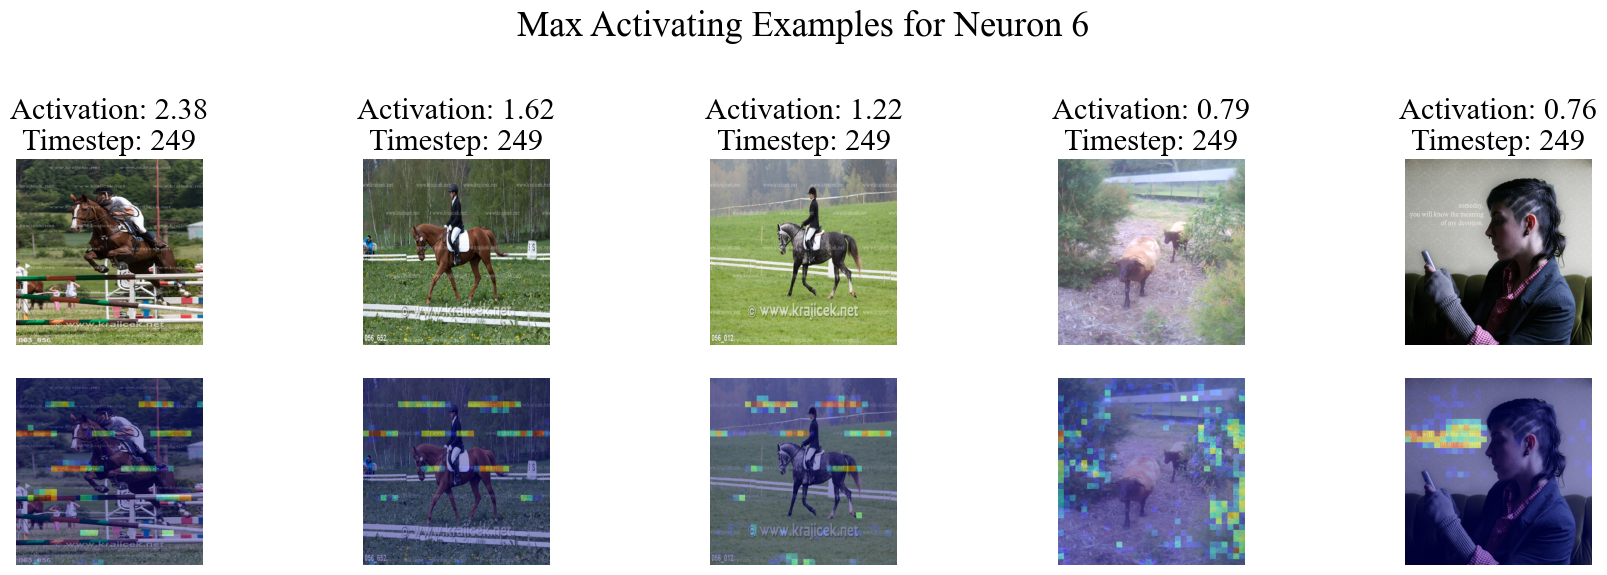

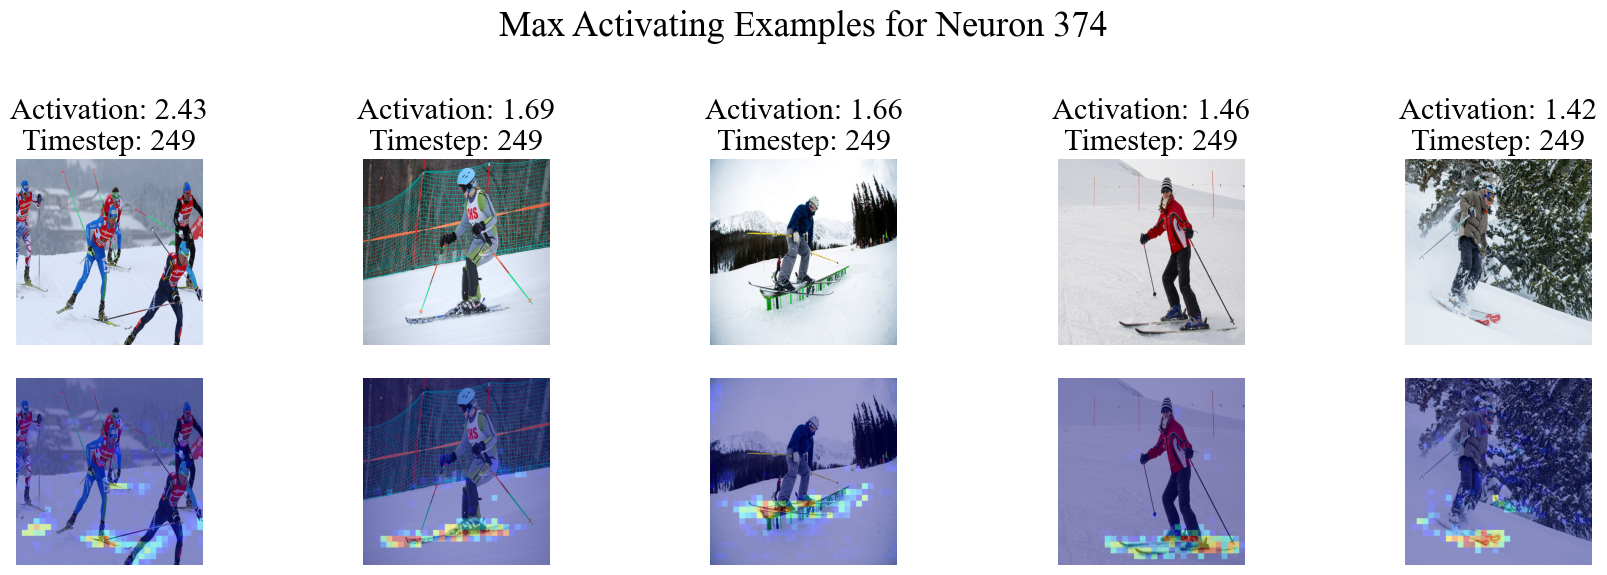

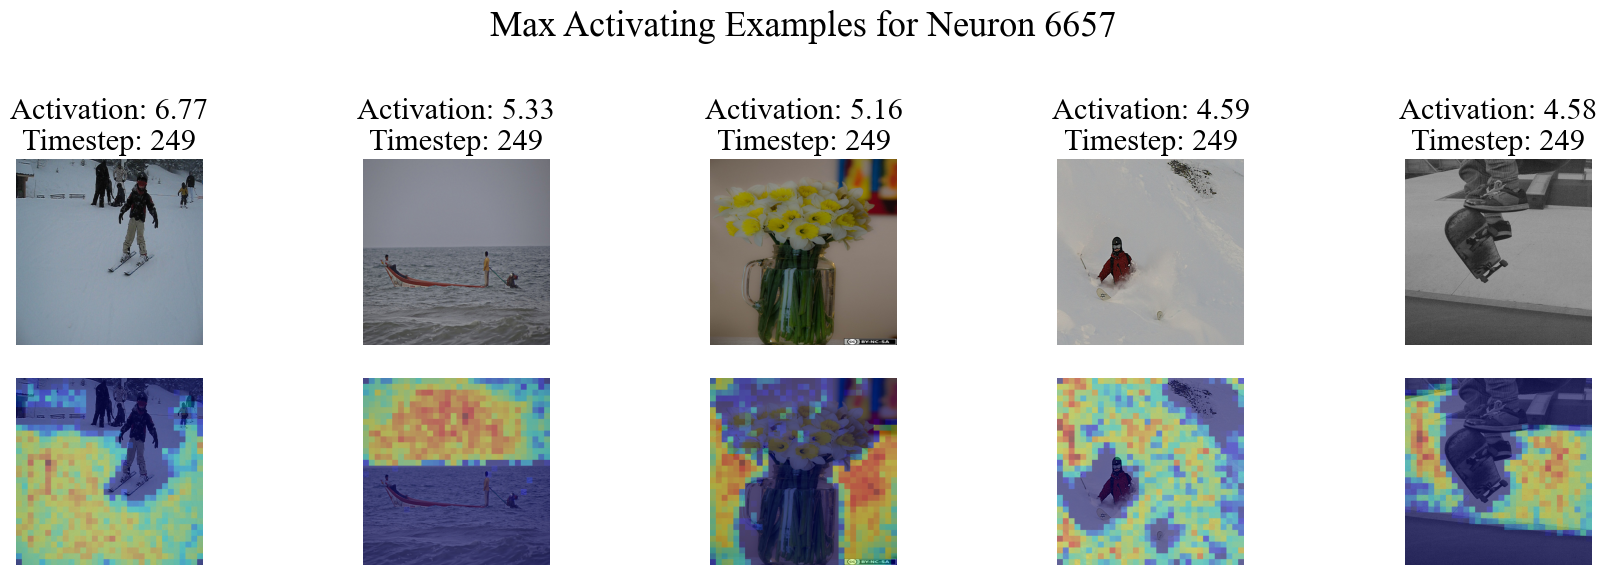

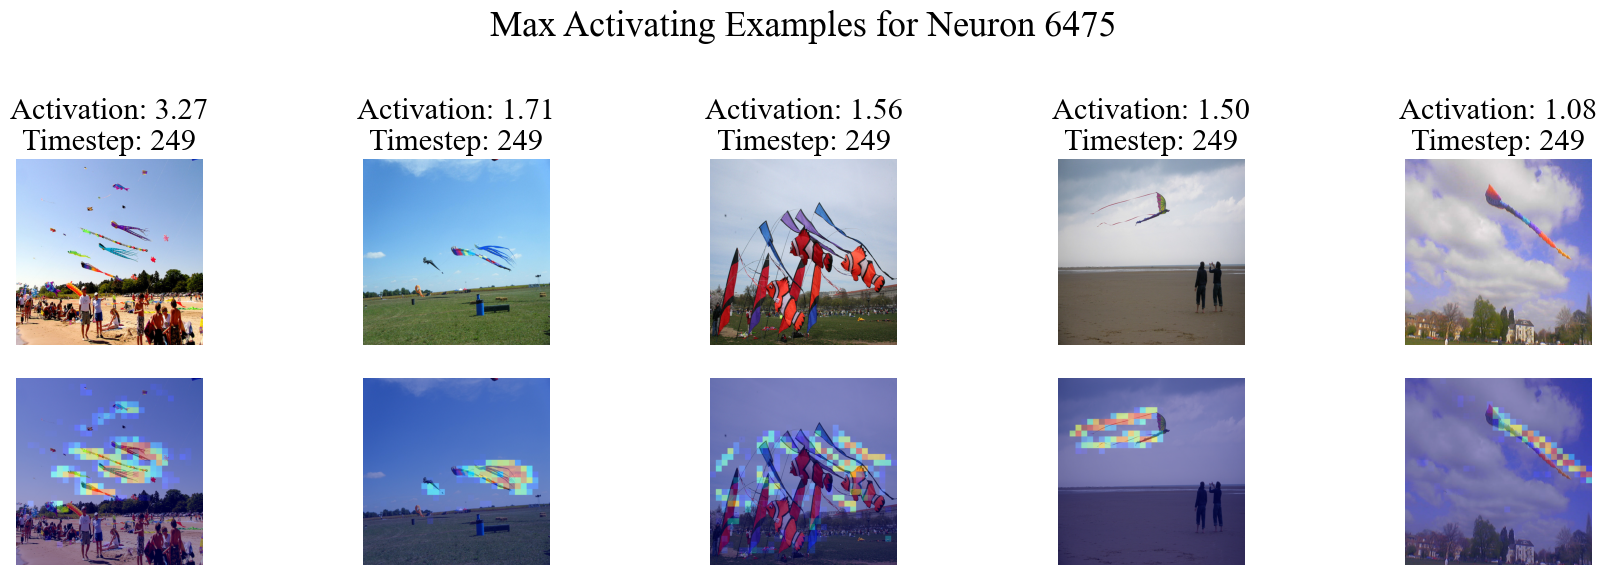

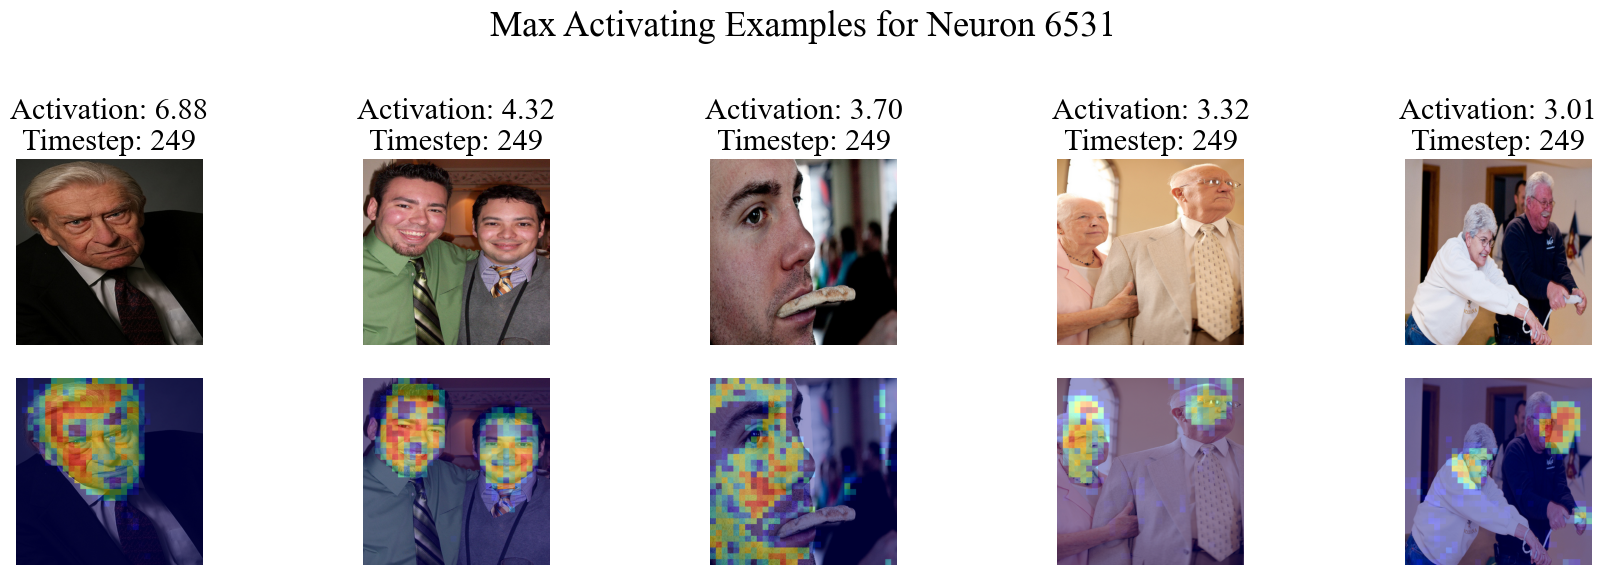

In [21]:
from tqdm import trange
k = 5
for latent_idx in [6, 374, 6657, 6475, 6531]:
# for latent_idx in trange(sae.num_latents, desc="Plotting max activating examples for latent neurons"):
	# if avg_activations[latent_idx] < 0.1:
		# continue

	topk_indices = find_topk_activating_examples(
		avg_activations_per_sample, latent_idx, k
	)  # find topk samples containing patches with higest activations
	topk_samples = activations_dataset[topk_indices.tolist()]
	sae_latents = []
	activations = topk_samples["activations"].to(sae.device)
	timesteps = topk_samples["timestep"]
	file_names_topk = topk_samples["file_name"]
	activations = einops.rearrange(
		activations,
		"batch sample_size d_model -> (batch sample_size) d_model",
	)
	out = sae.pre_acts(activations)
	sae_latents = out.view(k, -1, sae.num_latents)


	fig, axes = plt.subplots(2, len(topk_indices), figsize=(18, 6))

	# Plot max activating examples in two rows:
	# Row 1: Original images
	# Row 2: Model activations
	for i in range(len(topk_indices)):
		# Model 1 images
		img = Image.open(os.path.join(dataset_path, file_names_topk[i]))
		img = img.resize((512, 512))
		img = img.convert("RGB")

		# Process activations for model 1
		sae_latent_activations = sae_latents[i].reshape(
			int(torch.sqrt(torch.tensor(sae_latents.shape[1])).item()),
			int(torch.sqrt(torch.tensor(sae_latents.shape[1])).item()),
			-1,
		)[:, :, latent_idx]
		# Convert latent activations to numpy and normalize
		activation_map = sae_latent_activations[:, :].detach().cpu().numpy()
		activation_map = (activation_map - activation_map.min()) / (
			activation_map.max() - activation_map.min() + 1e-8
		)

		# Calculate upscale factor to match image size for model 1
		patch_size = 512 // activation_map.shape[0]
		activation_map = np.kron(activation_map, np.ones((patch_size, patch_size)))

		# Create heatmap overlays
		heatmap = np.uint8(plt.cm.jet(activation_map)[..., :3] * 255)
		heatmap = Image.fromarray(heatmap)

		# Blend original images with heatmaps
		blended_img = Image.blend(img, heatmap, alpha=0.4)

		# Calculate average activation for the image
		avg_activation = sae_latent_activations.mean().item()

		# Row 1: Original images
		axes[0, i].imshow(img)
		axes[0, i].axis("off")
		axes[0, i].set_title(
		    f"Activation: {avg_activation:.2f}\nTimestep: {int(timesteps[i].item())}",
		    fontsize=SMALL_SIZE,
		)
		if i == 0:
			axes[0, 0].set_ylabel("Original Images", fontsize=SMALL_SIZE)

		# Row 2: Activations
		axes[1, i].imshow(blended_img)
		axes[1, i].axis("off")
		if i == 0:
			axes[1, 0].set_ylabel("Activations", fontsize=SMALL_SIZE)

	plt.suptitle(f"Max Activating Examples for Neuron {latent_idx}", fontsize=BIGGER_SIZE)
	plt.tight_layout()
	# plt.savefig(
	# 	f"top_activating_examples_step249/coco2017_sdxl-turbo_topk_activating_examples_{latent_idx}.png",
	# 	bbox_inches="tight",
	# )
	plt.show()
	plt.close(fig)


## Dead neurons

In [32]:
avg_activations = avg_activations_per_sample.mean(dim=0).cpu().numpy()

/var/folders/kq/0cmrq_zj57z2937jvd8kd7dc0000gn/T/ipykernel_24846/2764203195.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


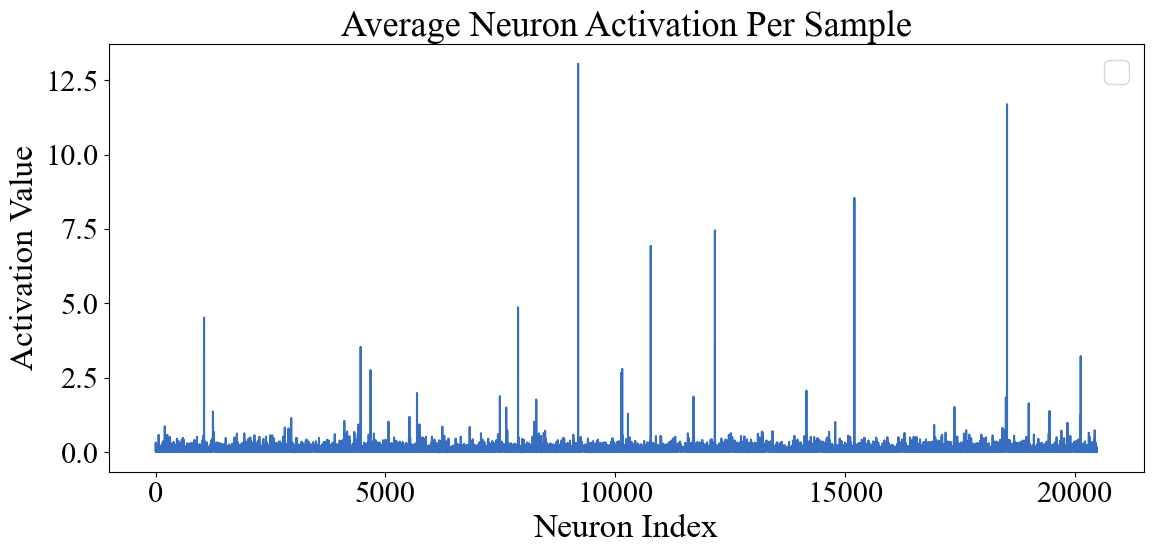

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    np.arange(len(avg_activations)),
    avg_activations,
    color=colors[0],
)
ax.set_xlabel("Neuron Index", fontsize=MEDIUM_SIZE)
ax.set_ylabel("Activation Value", fontsize=MEDIUM_SIZE)
ax.set_title("Average Neuron Activation Per Sample", fontsize=BIGGER_SIZE)
ax.legend()
plt.tight_layout()
# plt.savefig(
#     "figures/coco2017_sdxl-turbo_average_activations.png",
#     bbox_inches="tight",
# )
plt.show()

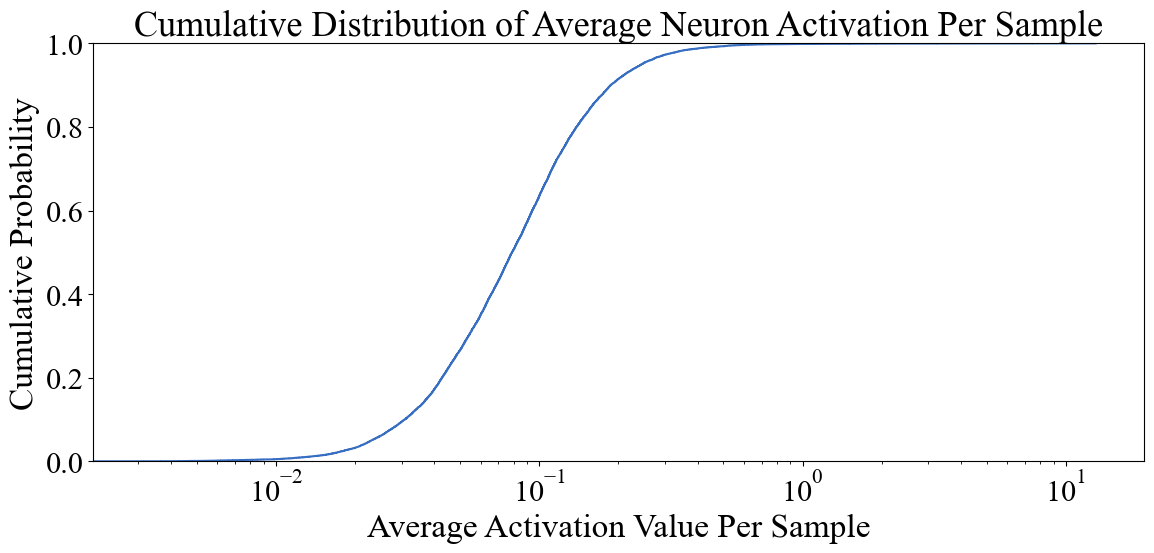

In [34]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.ecdfplot(
    avg_activations,
    color=colors[0],
)

ax.set_xlabel("Average Activation Value Per Sample", fontsize=MEDIUM_SIZE)
ax.set_ylabel("Cumulative Probability", fontsize=MEDIUM_SIZE)
ax.set_xscale("log")
ax.set_title(
	"Cumulative Distribution of Average Neuron Activation Per Sample", fontsize=BIGGER_SIZE
)
plt.tight_layout()
# plt.savefig(
#     "figures/coco2017_sdxl-turbo_average_activations.png",
#     bbox_inches="tight",
# )
plt.show()


In [35]:

batch_size = 16
dl = torch.utils.data.DataLoader(
	activations_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
average_activation_per_latent = torch.zeros(sae.num_latents, dtype=torch.float32)
activation_frequency_per_latent = torch.zeros(sae.num_latents, dtype=torch.float32)
num_tokens = 0
with torch.no_grad():
	for i, batch in tqdm(enumerate(dl), total=len(dl)):
		acts = batch["activations"].to(sae.device)
		acts = einops.rearrange(
			acts,
			"batch sample_size d_model -> (batch sample_size) d_model",
		)
		out = sae.pre_acts(acts) # [batch * sample_size, num_latents]
		average_activation_per_latent += out.sum(dim=0).cpu()
		activation_frequency_per_latent += (out > 1e-6).sum(dim=0).cpu()
		num_tokens += out.shape[0]

average_activation_per_latent /= num_tokens
activation_frequency_per_latent /= num_tokens

100%|██████████| 313/313 [01:26<00:00,  3.61it/s]


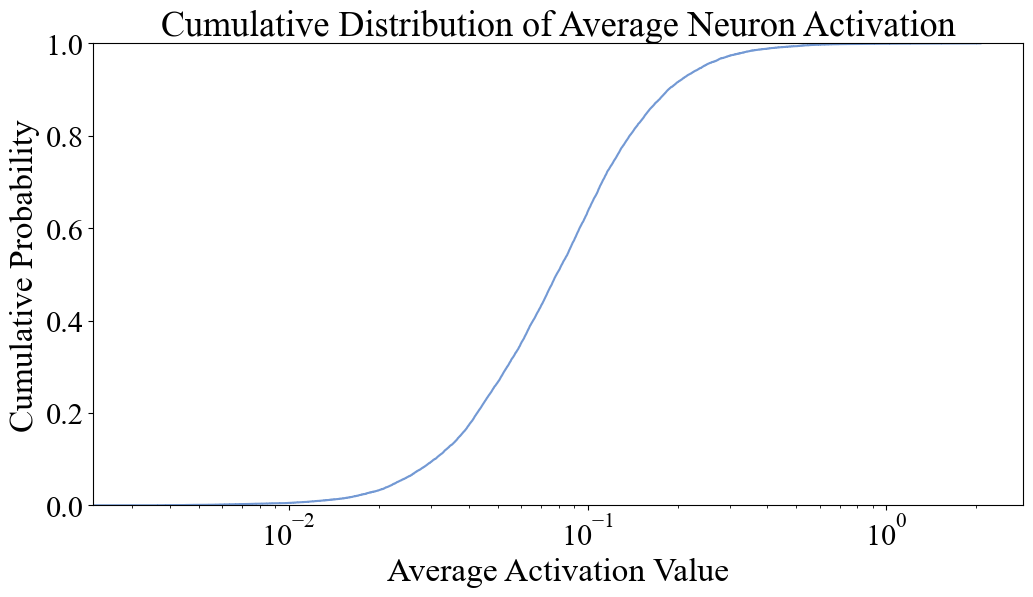

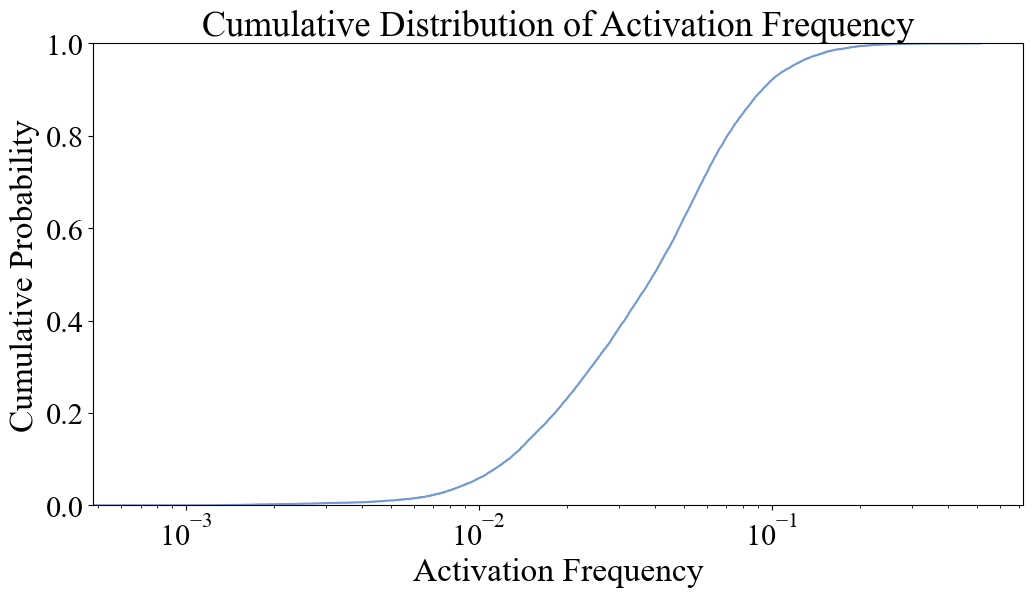

In [36]:

fig, ax = plt.subplots(figsize=(12, 6))
sns.ecdfplot(
	average_activation_per_latent.cpu().numpy(),
	color=colors[0],
	alpha=0.7,
)
ax.set_xscale("log")
ax.set_xlabel("Average Activation Value", fontsize=MEDIUM_SIZE)
ax.set_ylabel("Cumulative Probability", fontsize=MEDIUM_SIZE)
ax.set_title(
	"Cumulative Distribution of Average Neuron Activation", fontsize=BIGGER_SIZE
)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
sns.ecdfplot(
	activation_frequency_per_latent.cpu().numpy(),
	color=colors[0],
	alpha=0.7,
)
ax.set_xscale("log")
ax.set_xlabel("Activation Frequency", fontsize=MEDIUM_SIZE)
ax.set_ylabel("Cumulative Probability", fontsize=MEDIUM_SIZE)
ax.set_title(
	"Cumulative Distribution of Activation Frequency", fontsize=BIGGER_SIZE
)
plt.show()

100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


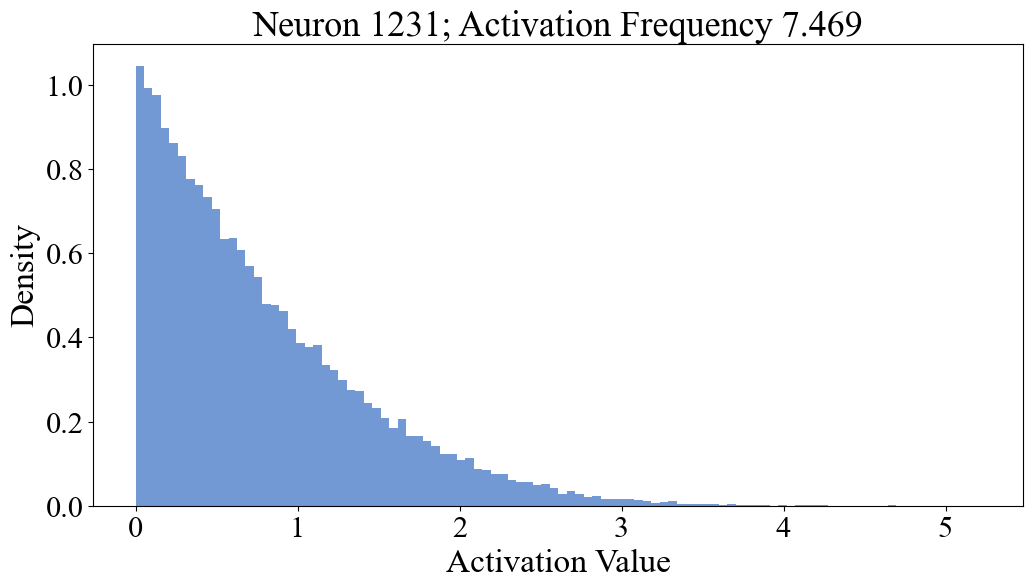

In [ ]:
latent_idx = 1231

batch_size = 16
dl = torch.utils.data.DataLoader(
	activations_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
sample_size = activations_dataset[0]["activations"].shape[0]
activations_per_latent = torch.zeros(
	(len(activations_dataset), sample_size), dtype=torch.float16
)
with torch.no_grad():
	for i, batch in tqdm(enumerate(dl), total=len(dl)):
		acts = batch["activations"].to(sae.device)
		acts = einops.rearrange(
			acts,
			"batch sample_size d_model -> (batch sample_size) d_model",
		)
		out = sae.pre_acts(acts) # [batch * sample_size, num_latents]
		batch_latent_activations = out[:, latent_idx].reshape(batch["activations"].shape[0], -1) # [batch, sample_size]
		start_idx = i * batch_size
		end_idx = min(start_idx + batch_size, len(activations_dataset))
		activations_per_latent[start_idx:end_idx] = batch_latent_activations


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(
	activations_per_latent.flatten()[activations_per_latent.flatten() > 1e-9],
	bins=100,
	color=colors[0],
	alpha=0.7,
    density=True,
)
ax.set_xlabel("Activation Value", fontsize=MEDIUM_SIZE)
ax.set_ylabel("Density", fontsize=MEDIUM_SIZE)
ax.set_title(
	f"Neuron {latent_idx}; Activation Frequency {activations_per_latent.flatten().sum() / activations_per_latent.numel() * 100:.3f}", fontsize=BIGGER_SIZE
)
plt.show()
plt.close(fig)